## MTGP + qnEHVI
### SNU에서 보내준 실제 output으로 코드 진행
#### 24/08/23

In [1]:
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.utils.sampling import draw_sobol_samples
from botorch.models import KroneckerMultiTaskGP, SingleTaskGP
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.constraints import GreaterThan, LessThan, Interval, Positive
from botorch.fit import fit_gpytorch_mll, fit_gpytorch_model
from gpytorch.kernels import MaternKernel, RBFKernel
from gpytorch.priors.torch_priors import GammaPrior, NormalPrior
import os
import torch
import numpy as np
import warnings 
import matplotlib.pyplot as plt
from scipy.stats import gamma
from gpytorch.priors import LKJCovariancePrior
from gpytorch.priors.smoothed_box_prior import SmoothedBoxPrior

warnings.filterwarnings("ignore", category=RuntimeWarning)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [2]:
train_x = np.load('SNU_Traindata_x_240823_1st.npy')
train_y = np.load('SNU_Traindata_y_240826_2nd_test.npy')

train_x = torch.from_numpy(train_x).to(**tkwargs) #10개 데이터
train_y = torch.from_numpy(train_y).to(**tkwargs) # 0 index: Vth , 1 index: Mobility

In [3]:
print(train_y)

tensor([[-0.0650, -0.2184],
        [-0.0350, -0.9540],
        [ 0.4520,  0.7241],
        [-1.0620, -0.4943],
        [-0.0500, -0.7471],
        [ 0.9560, -0.8851],
        [ 0.4060,  1.0000],
        [-0.0690,  0.8621],
        [-0.0600,  0.5402],
        [ 0.4000, -1.0000]], device='cuda:0', dtype=torch.float64)


In [4]:
# Data cov matrix
batch_shape, ard_num_dims = train_x.shape[:-2], train_x.shape[-1]

initial_point = torch.tensor([5., 2., 20,], **tkwargs)

Custom_RBF_kernel = MaternKernel(
    nu = 1.5,
    initial_lengthscale = initial_point,
    lengthscale_prior = None,
    lengthscale_constraint=Interval(1e0, 1e2),
    ard_num_dims = ard_num_dims,
    batch_shape = batch_shape,
)
# amplitude 설정
Custom_RBF_kernel.amplitude = 2.

# Task cov matrix
num_task = train_y.shape[-1]

Custom_Task_kernel = LKJCovariancePrior(
                n=num_task,
                eta = torch.tensor(1.5).to(train_x),
                sd_prior = SmoothedBoxPrior(np.exp(0), np.exp(1), 0.01),
                )

In [5]:
mtgp = KroneckerMultiTaskGP(train_x, train_y, 
                            data_covar_module=Custom_RBF_kernel,
                            task_covar_prior=Custom_Task_kernel)
#mtgp.likelihood.register_constraint("raw_noise", Interval(1e-4, 1e-3))
mtgp_mll = ExactMarginalLogLikelihood(mtgp.likelihood, mtgp)
fit_gpytorch_model(mtgp_mll)

ExactMarginalLogLikelihood(
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-04)
    (raw_task_noises_prior): GammaPrior()
    (raw_noise_constraint): GreaterThan(1.000E-04)
    (raw_noise_prior): GammaPrior()
  )
  (model): KroneckerMultiTaskGP(
    (likelihood): MultitaskGaussianLikelihood(
      (raw_task_noises_constraint): GreaterThan(1.000E-04)
      (raw_task_noises_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
      (raw_noise_prior): GammaPrior()
    )
    (mean_module): MultitaskMean(
      (base_means): ModuleList(
        (0-1): 2 x ConstantMean()
      )
    )
    (covar_module): MultitaskKernel(
      (task_covar_module): IndexKernel(
        (IndexKernelPrior): LKJCovariancePrior()
        (raw_var_constraint): Positive()
      )
      (data_covar_module): MaternKernel(
        (raw_lengthscale_constraint): Interval(1.000E+00, 1.000E+02)
      )
    )
  )
)

In [6]:
# MTGP 모델에서 각 태스크의 길이 스케일 가져오기
length_scales = mtgp.covar_module.data_covar_module.lengthscale
task_cov_matrix = mtgp.covar_module.task_covar_module.covar_factor
print(length_scales)
print(task_cov_matrix)

tensor([[100.0000,  11.1349,  99.9945]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
Parameter containing:
tensor([[-0.3773, -0.5570],
        [-0.5586,  0.8261]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)


In [7]:
for name, param in mtgp.named_parameters():
    print(f"Parameter name: {name}, Value: {param}")

Parameter name: likelihood.raw_task_noises, Value: Parameter containing:
tensor([0.0708, 0.0454], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter name: likelihood.raw_noise, Value: Parameter containing:
tensor([0.0280], device='cuda:0', dtype=torch.float64, requires_grad=True)
Parameter name: mean_module.base_means.0.raw_constant, Value: Parameter containing:
tensor(-0.3833, device='cuda:0', dtype=torch.float64, requires_grad=True)
Parameter name: mean_module.base_means.1.raw_constant, Value: Parameter containing:
tensor(0.3356, device='cuda:0', dtype=torch.float64, requires_grad=True)
Parameter name: covar_module.task_covar_module.covar_factor, Value: Parameter containing:
tensor([[-0.3773, -0.5570],
        [-0.5586,  0.8261]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter name: covar_module.task_covar_module.raw_var, Value: Parameter containing:
tensor([-0.3178, -4.0835], device='cuda:0', dtype=torch.float64,
       requires_gr

In [8]:
mtgp.eval()
with torch.no_grad():
    pred = mtgp.posterior(train_x).mean

Text(0, 0.5, 'Normalized Mobility')

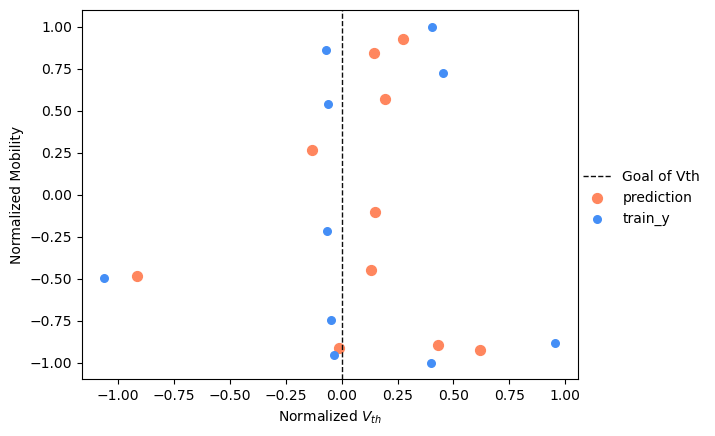

In [9]:
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt

plt.scatter(pred[:, 0].cpu().numpy(), pred[:, 1].cpu().numpy(),s=50, label='prediction', c='#FF865E')
plt.scatter(train_y[:, 0].cpu().numpy(), train_y[:, 1].cpu().numpy(),s=30, label='train_y', c='#448EF6')
V_th_goal = 0.
plt.axvline(V_th_goal, 0, 1, color='#0C0C0C', linestyle='--', linewidth=1, label='Goal of Vth')

plt.legend(frameon=False, loc=(1,0.4))
plt.xlabel("Normalized $V_{th}$")
plt.ylabel("Normalized Mobility")

In [10]:
with open('SNU_BF_data_240823.npy', 'rb') as f:
    BF_val_x=np.load(f, allow_pickle=True) 
    BF_val_x=np.float64(BF_val_x)
    BF_val_x = torch.from_numpy(BF_val_x).to(**tkwargs)

In [11]:
mtgp.eval()
with torch.no_grad():
    pred_BF = mtgp.posterior(BF_val_x).mean
    var_BF = mtgp.posterior(BF_val_x).variance
    
var_to_std = torch.sqrt(var_BF)
std_BF = var_to_std.cpu().detach().numpy() 

(-2.0, 1.5)

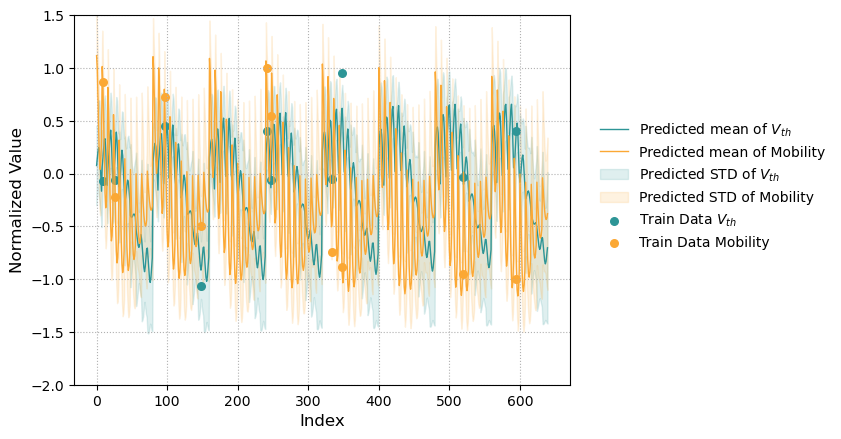

In [12]:
def find_row(arr, target_row):
    for i, row in enumerate(arr):
        if np.array_equal(row, target_row):
            return i
    return None  # 행을 찾지 못한 경우 None 반환
train_x_hand = np.load('SNU_Traindata_x_240823_1st.npy')
X_scatter = []

with open('SNU_BF_data_240823.npy', 'rb') as f:
    grid_array=np.load(f, allow_pickle=True) 
    current_x_junk=np.float32(grid_array)

BF_x_array = torch.from_numpy(current_x_junk).float()

# 두 배열을 동일한 데이터 타입으로 변환
Sample_X_new = train_x_hand.astype(np.float32)

# 함수 호출하여 행 찾기
for i in range(Sample_X_new.shape[0]):
    result = find_row(BF_x_array, Sample_X_new[i,:])
    X_scatter = np.append(X_scatter, result)
    
x = range(len(pred_BF[:,0]))
pred_BF = pred_BF.cpu().numpy()

plt.plot(x, pred_BF[:,0], linewidth=1., color = '#2D9596', label = 'Predicted mean of $V_{th}$')
plt.fill_between(x, pred_BF[:,0]-std_BF[:,0], pred_BF[:,0]+std_BF[:,0], color='#2D9596', alpha=0.15, label = 'Predicted STD of $V_{th}$')

plt.plot(x, pred_BF[:,1], linewidth=1., color = '#FBA834', label = 'Predicted mean of Mobility')
plt.fill_between(x, pred_BF[:,1]-std_BF[:,1], pred_BF[:,1]+std_BF[:,1], color='#FBA834', alpha=0.15, label = 'Predicted STD of Mobility')

plt.scatter(X_scatter, train_y[:,0].cpu(), color = '#2D9596', label='Train Data $V_{th}$', s=30) 
plt.scatter(X_scatter, train_y[:,1].cpu(), color = '#FBA834', label='Train Data Mobility', s=30)

plt.xlabel('Index', fontsize = 12)
plt.ylabel('Normalized Value', fontsize = 12)
plt.legend(frameon=False, loc=(1.05,0.35))
plt.grid(True, linestyle=':' )
plt.ylim([-2, 1.5])
#plt.xlim([200, 400])
#plt.savefig('#1_model_Regression_Plot.png')

In [13]:
type(std_BF[:,1])
np.savetxt('Initial_STD_Mobility_MTGP_240930.txt', std_BF[:,1])

# Model Evaluation

In [ ]:
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from typing import List, Optional
from torch import Tensor
from botorch.optim.optimize import optimize_acqf, optimize_acqf_discrete
from botorch.acquisition.multi_objective.objective import GenericMCMultiOutputObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.utils.sampling import sample_simplex
import itertools

dim1_values = range(5, 45, 5) 
dim2_values = range(2, 22, 2)  
dim3_values = range(30, 190, 20)  

all_combinations = list(itertools.product(dim1_values, dim2_values, dim3_values))
all_combinations_np = np.array(all_combinations)
choices = torch.from_numpy(all_combinations_np).to(**tkwargs)

In [ ]:
#reference point V_th, Mobility
ref_point = torch.tensor([-0.1813196,  -1.04942529], **tkwargs)

# Vth는 0과의 difference로 들어가서 0이 제일 크도록.
def custom_objective_modified(Y, X):
    #V_th_goal = torch.tensor(0, **tkwargs)
    return torch.stack([-(Y[..., 0].pow(2)), Y[..., 1]], dim=-1)

objective = GenericMCMultiOutputObjective(objective=custom_objective_modified)

In [ ]:
BATCH_SIZE = 4

def optimize_qnehvi_and_get_observation(model, train_x, train_obj, sampler):
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.tolist(),  # use known reference point
        X_baseline=train_x, # design points that have already been observed. 
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
        objective=objective,
        cache_root=False,
    )
    # optimize
    candidates, acq_value = optimize_acqf_discrete(
    acq_function=acq_func,
    q=BATCH_SIZE,  
    choices=choices,
    max_batch_size=10, 
    unique=True, 
    )
    # observe new values
    new_x = candidates.detach()

    return new_x

In [ ]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated

warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

MC_SAMPLES = 2000

# define the qEI and qNEI acquisition modules using a QMC sampler
qnehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    # optimize acquisition functions and get new observations
new_x_qnehvi = optimize_qnehvi_and_get_observation(
        mtgp, train_x, train_y, qnehvi_sampler
    )

mtgp.eval()
with torch.no_grad():
    pred_qnehvi_can = mtgp.posterior(new_x_qnehvi).mean
    var_qnehvi_can = mtgp.posterior(new_x_qnehvi).variance
    
var_to_std = torch.sqrt(var_qnehvi_can)
std_qnehvi_can = var_to_std.cpu().detach().numpy()

In [ ]:
print(new_x_qnehvi)
print(pred_qnehvi_can)
print(train_x)

# Compute Hypervolume

In [ ]:
bd = DominatedPartitioning(ref_point=ref_point, Y=train_y)
volume = bd.compute_hypervolume().item()

print(volume)

In [ ]:
plt.scatter(pred_qnehvi_can[:, 0].cpu().numpy(),pred_qnehvi_can[:, 1].cpu().numpy(),
            color='#D74B76', alpha=0.8,s=30,label ='qnehvi')


plt.errorbar(pred_qnehvi_can[:, 0].cpu().numpy(),pred_qnehvi_can[:, 1].cpu().numpy(), 
             xerr=std_qnehvi_can[:,0], yerr=std_qnehvi_can[:,1], 
             color='#D74B76', fmt='o', alpha=0.8, markersize=1, label ='std')

plt.scatter(pred[:, 0].cpu().numpy(), pred[:, 1].cpu().numpy(),s=50, label='prediction', c='#FF865E')
plt.scatter(train_y[:, 0].cpu().numpy(), train_y[:, 1].cpu().numpy(),s=30, label='train_y', c='#448EF6')
V_th_goal = 0.

plt.legend(frameon=False, loc=(1,0.4))

#수직선
V_th_goal = 0.
plt.axvline(V_th_goal, 0, 1, color='#0C0C0C', linestyle='--', linewidth=1, label='Goal of Normalized Vth')
#plt.scatter(pred_BF[:, 0],pred_BF[:, 1],alpha=0.8,s=10,label ='Brute Force')
#plt.scatter(train_y[:, 0].cpu().numpy(),train_y[:, 1].cpu().numpy(),alpha=1.,s=10,label='train_y', color='red')

plt.grid(True, linestyle=':')
plt.legend(frameon=False, loc=(1.02,0.29))
plt.xlabel("Normalized Vth")
plt.ylabel("Normalized Mobility")

# Model Save

In [ ]:
torch.save(mtgp.state_dict(), 'MTGP_Model_240827_successful.pth')

# Candidate Save

In [14]:
def denormalize_Mob(x_norm, x_min, x_max):
    # 역정규화 공식 적용
    x = x_norm * (x_max - x_min) / 2 + (x_max + x_min) / 2
    return x

In [15]:
copy_pred_qnehvi_mean = torch.tensor(pred_qnehvi_can)
copy_pred_qnehvi_std = torch.tensor(std_qnehvi_can)

print("1st Candidate Vth Mean:", copy_pred_qnehvi_mean[:,0].cpu().numpy(), 
      "\n 1st Candidate STD:", copy_pred_qnehvi_std[:,0].cpu().numpy())

NameError: name 'pred_qnehvi_can' is not defined

In [16]:
print(std_BF)

[[0.37755805 0.37885889]
 [0.27197277 0.27228321]
 [0.35359204 0.35484089]
 ...
 [0.56605711 0.56858783]
 [0.64180423 0.64498381]
 [0.71737744 0.72115077]]


In [17]:
#Mobility
Mobility_original = np.array([21.4, 18.2, 25.5,20.2, 19.1, 18.5, 26.7, 26.1, 24.7, 18.0])
min_value = min(Mobility_original)
max_value = max(Mobility_original)

# 역정규화 수행
denormalized_qnEHVI_Mobility_mean = denormalize_Mob(copy_pred_qnehvi_mean[:,1].cpu().numpy(), min_value, max_value)
denormalized_qnEHVI_Mobility_std = denormalize_Mob(copy_pred_qnehvi_std[:,1].cpu().numpy(), min_value, max_value)

print("Normalized Data:", copy_pred_qnehvi_mean[:,1], copy_pred_qnehvi_std[:,1])
print("Denormalized Mean:", denormalized_qnEHVI_Mobility_mean)
print("Denormalized STD", denormalized_qnEHVI_Mobility_std)

NameError: name 'copy_pred_qnehvi_mean' is not defined

In [ ]:
train_y_new = train_y
Eval_Vth_new = -(train_y_new[:,0].pow(2))
train_y_new[:,0] = Eval_Vth_new

In [ ]:
bd = DominatedPartitioning(ref_point=ref_point, Y=train_y_new)
volume = bd.compute_hypervolume().item()

print(volume)